## Rain in Australia

Dataset: [Australia Rain](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package)\
kaggle API command: kaggle datasets download -d jsphyg/weather-dataset-rattle-package

In [65]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

In [66]:
root = os.getcwd()
filefolder = os.path.join(root, 'data', 'rain')
filename = os.listdir(filefolder)[0]  #only 1 file in this folder
file_path = os.path.join(filefolder, filename)

In [67]:
## read file into a dataframe
df_orig = pd.read_csv(file_path)

In [68]:
## Create a copy of the original dataframe
df = df_orig.copy()

### Exploratory Data Analysis & Data Pre-processing

1. Target variable for this data set is the RainTomorrow variable
2. The data has both time series and geographical data, there could be strong spatial and temporal autocorrelations in the data
    * Spatial correlations could be hard to estimate. One way to go about it is to get lat/long data for the locations mentioned
3. We approach this data set by exploring perculiarities in the dataset related to:
    * Missing data
        * Non-contiguous date ranges
        * Missing values from individual attributes
        * Missing values from target
    * Outliers: Plot distribution of qunatitative variables and scan for any outliers
4. Determine appropriate treatment for handling:
    * Missing values: 
        * Drop certain attributes/locations data
        * Forward & backward fills (ffill & bfill)
        * Imputation by median value 
        * Imputation by 3-day moving average
        * Check high-level statistics using describe() and difference between above three approaches
    * Outliers:
        * Drop extreme values on both sides
        * Drop inconsistent values (Ex: negative numbers)
        * Winsorization (Clipping)
5. Visualize distributions and Correlations between independent attributes in the dataset
6. Add derived variables: 
    * Temperature range  
7. Data pre-procesing:
    * Type-conversions: Dates, float, timedeltas, etc.

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Highlevel over-view fo the Dataset

By running the ```.info()``` method on the data set we make the following observations;
* Data set has a total of 23 attributes includin the target variable
* About 145K instances of data
* Certain attributes, such as 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm' have a lot of missing values in the dataset
* The Date colums is of 'object' dtype. Need to convert it into datetime
* RainToday & RainTomorrow and Rainfall column could be helpful in filling out missing values in target variable
* Taking a cursory glance using ```.head()``` below, the rest of the columns seems to be having the right dtypes
* Target variable is binary, coded as 'Yes/No'

In [70]:
## Cursory glance at the dataset
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [71]:
df.describe()

MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.000000      13.000000   
50%        8.400000      39.000000      13.000000      19.000000   
75%       10.600000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm   Pressure9am    Pressure3pm  \
count  142806.000000  140953.000000  130395.00000  130432.000000   
mean       68.880831      51.539116    1017.64994    1015.255889   
std        19.029164      20.795902       7.10653       7.037414   
min         0.000000       0.000000     980.50000     977.100000   
25%        57.000000      37.000000    1012.90000    1010.400000   
50%        70.000000      52.000000    1017.60000    1015.200000   
75%        83.000000      66.000000    1022.40000    1020.000000   
max       100.000000     100.000000    1041.00000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am       Temp3pm  
count  89572.000000  86102.000000  143693.000000  141851.00000  
mean       4.447461      4.509930      16.990631      21.68339  
std        2.887159      2.720357       6.488753       6.93665  
min        0.000000      0.000000      -7.200000      -5.40000  
25%        1.000000      2.000000      12.300000      16.60000  
50%        5.000000      5.000000      16.700000      21.10000  
75%        7.000000      7.000000      21.600000      26.40000  
max        9.000000      9.000000      40.200000      46.70000

### High-level descriptive statistics of quantitative variables in the dataset

By running the ```.describe()``` method on the data set we make the following observations;
* MinTemp & MaxTemp variables seem to be within expectations without any extreme values
    * max value is within 4 standard deviations of the mean
* Variables such as Rainfall, Evaporation, WindSpeed definitely have extreme values
* Stats for MaxTemp are quite close to stats for temp3pm. we can leverage this is imputing missing values in either of the columns
* Median rainfall is 0mm and 75%le is <1mm, indicating that the data set is imbalanced and it did not rain on mostof the days recorded in the dataset
* Humidity measurements are scaled to lie between 0-100

**Checking for irregularities in timeseries/date ranges**
The ```.diff()``` function is very helpful in figuring out is the ranges of dates in the data set is contiguous.

* The below piece of code checks for 'gaps' in data set for each of the locations
* The gaps colums gives the number of dates missing prior to the date in the current row
* Re-naming the series object sets a column name to the series and helps woth referencing in the next step
* The ```.diff()``` operator produces differences as time delta. Hence filtering on this column should be done using timedeltas for comparison operations

In [72]:
## Start by conveting the Date column to datetime
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

## Check for irregularities in time series
gaps = df.groupby(['Location', 'Date'])['Date'].mean().diff().rename('gaps').reset_index()  #rename is used to re-name the series object
gaps[gaps.gaps > pd.Timedelta(value=1, unit='days')]

Location       Date    gaps
1004      Adelaide 2011-05-01 31 days
1584      Adelaide 2013-01-01 32 days
1615      Adelaide 2013-03-01 29 days
4044        Albany 2011-05-01 31 days
4624        Albany 2013-01-01 32 days
...            ...        ...     ...
140842  Wollongong 2013-01-01 32 days
140873  Wollongong 2013-03-01 29 days
143271     Woomera 2011-05-01 31 days
143851     Woomera 2013-01-01 32 days
143882     Woomera 2013-03-01 29 days

[143 rows x 3 columns]

**Contiguoug date range**
Based on the resuls from above, we see that there are quite a few dates missing accross locations
We can address this by generating a series of contiguous dates based on the earliest and latest dates available in the dateset
We then create a cross-join of the date range with the locations available in the data set.
This ensure that the same date-range is present for each of the locations mentioned in the dataset

In [73]:
## Start by creating an index of contiguous date ranges
dts = pd.date_range(start=df.Date.min(), end=df.Date.max(), freq='D')
## Get a list of distinct locations 
locs = df.Location.unique()

# Perform a cross join using itertools and convert to a DataFrame
cross_join = pd.DataFrame(itertools.product(dts, locs), columns=['Date', 'Location'])

# Merge the datafram from above with the original data frame as a full-join to impute all the missing dates
# into the original dataset
df = df.merge(cross_join, on=['Date', 'Location'], how='outer')

**Alternative way to create a cross-join in pandas**

```py
dts = pd.date_range(start=df.Date.min(), end=df.Date.max(), freq='D').to_frame(name='Date')
dts['key'] = 0
locs = pd.DataFrame(df.Location.unique(), columns=['Location'])
locs['key'] = 0
cross_join = dts.merge(locs, on='key', how='outer').drop('key', axis=1)
```

### Analysis of Missing values

We start by cheking the number of missing values across Dates and Locations
* From the below table we see that data is very sparse for dates prior to the year 2009
* There are also lactions such as 'Katherine', 'Nhil', 'Uluru' which do not have date prior to 2013
* Data for 2017 is also not available for the full year. We have data for a little over 6 months of 2017.
* Data for 2011, 2012 and 2013 is also missing for about 30 days from the full year, across all the locations
    * Upon closer inspection data is missing for full month of Apr'11, Dec'12 and Feb'13

In [74]:
## Cheking the number of missing values across the Dates and Locations 
df.groupby([df.Date.dt.year, 'Location'])['MinTemp'].count().unstack().T

## Digging deeper into the 30days of missing data in 2011, 2012 and 2013
df[df.Date.dt.year.isin([2011, 2012, 2013])]\
    .groupby([df.Date.dt.year, df.Date.dt.month, 'Location'])['MinTemp'].count().unstack()

Location   Adelaide  Albany  Albury  AliceSprings  BadgerysCreek  Ballarat  \
Date Date                                                                    
2011 1           31      31      31            31             31        31   
     2           28      28      28            28             28        27   
     3           31      31      31            31             31        31   
     4            0       0       0             0              0         0   
     5           31      31      31            31             31        31   
     6           30      30      30            30             30        30   
     7           31      31      31            31             31        31   
     8           31      31      31            31             31        31   
     9           30      30      27            30             30        30   
     10          31      31      31            31             31        31   
     11          30      30      30            30             30        30   
     12          31      31      31            31             31        31   
2012 1           31      30      31            31             31        31   
     2           29      29      29            29             29        29   
     3           31      31      31            31             31        31   
     4           30      29      30            30             30        30   
     5           31      31      31            31             31        31   
     6           30      28      30            30             30        30   
     7           31      31      31            31             31        31   
     8           31      31      31            31             31        31   
     9           30      30      30            30             30        30   
     10          31      31      31            31             31        31   
     11          30      30      30            30             30        30   
     12           0       0       0             0              0         0   
2013 1           31      30      31            31             31        31   
     2            0       0       0             0              0         0   
     3           31      30      31            31             31        31   
     4           30      30      30            30             30        30   
     5           31      31      31            31             31        31   
     6           30      30      30            30             30        30   
     7           31      31      31            31             31        31   
     8           31      31      31            31             31        31   
     9           30      30      30            30             30        30   
     10          31      31      30            31             31        31   
     11          30      30      30            30             30        30   
     12          31      31      31            31             31        31   

Location   Bendigo  Brisbane  Cairns  Canberra  ...  Townsville  Tuggeranong  \
Date Date                                       ...                            
2011 1          31        31      31        31  ...          31           31   
     2          28        28      28        28  ...          28           28   
     3          31        31      31        31  ...          31           31   
     4           0         0       0         0  ...           0            0   
     5          31        31      31        31  ...          31           31   
     6          30        30      30        30  ...          30           30   
     7          31        31      31        31  ...          31           31   
     8          31        31      31        31  ...          31           31   
     9          30        30      30        30  ...          30           30   
     10         31        31      31        31  ...          31           31   
     11         30        30      30        30  ...          30           3

* Based on the above observations, we may drop data prior to 2009 and also data from the locations 'Katherine', 'Nhil', 'Uluru' which were added later on in 2013.
* For the other set of missing values where the data is missing for a whole month in 2011, 2012 & 1023, its is difficult to make any meaningful imputation of data for a full month.
    * One way to go about this is to just drop the three months (Apr'11, Dec'12 and Feb'13) for which the data is missing

In [75]:
# Incomplete data.
## A. Dropping data prior to 2009
df = df[df.Date.dt.year>=2009]

Writting a simple function to get the number of missing values in the data set. We can leverage this function to check the 
missing values in the dataset after each action.

In [76]:
# Handling missing values
## Check for the % of missing values in the dataset
def get_missing(df):
    s = df.isna().sum(axis=0)*100/len(df)
    s = s[s>0].to_frame(name='miss_pct')
    s = s.join(df.dtypes.to_frame(name='data_type'), how='left')
    # s = s.merge(df.dtypes.to_frame(),how='left', left_index=True, right_index=True)
    return s

#### Calculating % of missing values in each column
get_missing(df)

miss_pct data_type
MinTemp         6.684365   float64
MaxTemp         6.538781   float64
Rainfall        7.845088   float64
Evaporation    46.853138   float64
Sunshine       51.504592   float64
WindGustDir    12.217230    object
WindGustSpeed  12.176388   float64
WindDir9am     12.613141    object
WindDir3pm      8.483419    object
WindSpeed9am    6.857617   float64
WindSpeed3pm    7.717948   float64
Humidity9am     7.445225   float64
Humidity3pm     8.667211   float64
Pressure9am    15.574894   float64
Pressure3pm    15.551179   float64
Cloud9am       42.280075   float64
Cloud3pm       44.559360   float64
Temp9am         6.864863   float64
Temp3pm         8.080262   float64
RainToday       7.845088    object
RainTomorrow    7.849699    object

A. From the above table we see that certain attributes have a high% of missing values. 
We can drop the following attributes with more than 20% (arbitrarily chosen) of data missing:
* Evaporation
* Sunshine
* Cloud9am
* Cloud3pm

B. There are also certain locations which do not have any values populated for certain attributes. We can identfy these locations based ont he below code. Given that there are only a hand few locations (<= 5 locations) we can drop them from the dataset.

In [77]:
# Handling missing values

## A. Dropping columns with high % of missing values
miss_cols = get_missing(df)
#### dropping coumns where there are more than 20% of values missing
miss_cols = miss_cols[miss_cols.miss_pct>20].index.values ## .values returs an nd-numpy array
miss_cols
df = df.drop(miss_cols, axis=1)

In [78]:
## B. Dropping Locations with missing values (i.e. data not being captured)

miss_loc = df.groupby('Location').count()
miss_loc = (miss_loc == 0).any(axis=1)
miss_loc = miss_loc[miss_loc==True].index.values

#### Check count of data points for these locations in the dataset
df['Location'].value_counts()/len(df)  # Most locations are pretty uniformly distributed interms of count

#### Based on the above looks like dropping these locations is not going to significantly impact the analysis
#### Dropping the locations missing ceratain variables
df = df[~df.Location.isin(miss_loc)]    # given that this is not an index based drop, instead of using the drop function we simply filter the dataset

In [79]:
## Getting the latest state of missing values after the above set of actions
get_missing(df)

miss_pct data_type
MinTemp         6.696402   float64
MaxTemp         6.651652   float64
Rainfall        8.137948   float64
WindGustDir     8.537766    object
WindGustSpeed   8.492282   float64
WindDir9am     11.839016    object
WindDir3pm      7.300164    object
WindSpeed9am    6.837256   float64
WindSpeed3pm    6.810846   float64
Humidity9am     7.340513   float64
Humidity3pm     7.810758   float64
Pressure9am     8.170227   float64
Pressure3pm     8.143817   float64
Temp9am         6.759493   float64
Temp3pm         7.210664   float64
RainToday       8.137948    object
RainTomorrow    8.143084    object

### Imputation of Missing values

The method of imputing missing values for quantitative variables would be different from that of imputing categorical variables.
There is also opportunity to impute values of a particular attribute based on available values of another attribute.

We start by trying the following imputations:
* Impute Temp3PM with MaxTemp and vice-versa
* If RainToday = No, then Rainfall is zero

In [80]:
## Opportunity to impute Temp3PM with MaxTemp and vice-versa
df['Temp3pm'] = df['Temp3pm'].combine_first(df['MaxTemp']) 
df['MaxTemp'] = df['MaxTemp'].combine_first(df['Temp3pm']) 

## Rainfall. If RainToday = No, then Rainfall is zero
df['Rainfall'] = np.where(df.RainToday == 'No', 0.0, df.Rainfall)
# df[df.Rainfall.notna()&df.RainToday.isna()][['Rainfall', 'RainToday']]

**Imputation of missing values for categorical variables**

For categorical variables, there is no great way to impute missing values.\
One method we could try is to use forward/backward fill of categorical variables.

In [81]:
## Imputation of missing values for categorical variables

cat_miss = get_missing(df)
cat_miss = cat_miss[cat_miss.data_type=='object'].index.values.tolist()
cat_miss = list(set(cat_miss)-set(['RainTomorrow', 'RainToday']))

# ## Forward filling missing categorical variables

df[cat_miss] = df[['Location', 'Date']+cat_miss].sort_values(by=['Location', 'Date'])\
        .groupby('Location').fillna(method='ffill', axis=0).fillna(method='bfill', axis=0)[cat_miss]

In [82]:
df = df.sort_values(by=['Location', 'Date'])

In [83]:
## Getting the latest state of missing values after the above set of actions
get_missing(df)

miss_pct data_type
MinTemp        6.696402   float64
MaxTemp        6.546746   float64
Rainfall       8.137948   float64
WindGustSpeed  8.492282   float64
WindSpeed9am   6.837256   float64
WindSpeed3pm   6.810846   float64
Humidity9am    7.340513   float64
Humidity3pm    7.810758   float64
Pressure9am    8.170227   float64
Pressure3pm    8.143817   float64
Temp9am        6.759493   float64
Temp3pm        6.546746   float64
RainToday      8.137948    object
RainTomorrow   8.143084    object

**Imputation of missing values for numeric variables**

There are three possible options to impute missing values for quantitative variables. 
* Method 1: Imputation with ffill/bfill
* Method 2: Imputation with simple mean/median
* Method 3: Imputation with rolling mean/median (simple/exponential)

While the all of the above methods are acceptable for imputing timeseries data, we observed from the above analysis that certain data was missing for a full month across 2011, 2012 and 2013.

However, for the sake of demonstartion, we try all three methods mentioned above. We may drop the missing date ranges, if needed, before the modeling step. 

In [84]:
# Getting a list of numerical variables
num_miss = get_missing(df)
num_miss = num_miss[num_miss.data_type!='object'].index.values.tolist()
num_miss = list(set(num_miss)-set(['Rainfall']))   # rainfall will be handled separately. Set needs a list passed set('Rainfall') didn't work 
num_miss

#### Method 1: Imputation with ffill/bfill
# df[num_miss] = df[['Location', 'Date']+num_miss].sort_values(by=['Location', 'Date'])\
#         .groupby('Location').fillna(method='ffill', axis=0).fillna(method='bfill', axis=0)[num_miss]
# stats_1 = df.describe().T

#### Method 2a: Imputation with simple mean
# df[num_miss] = df[num_miss].combine_first(df.groupby('Location')[num_miss].transform('mean'))
# stats_2a = df.describe().T

#### Method 2b: Imputation with simple median
# df[num_miss] = df[num_miss].combine_first(df.groupby('Location')[num_miss].transform('median'))
# stats_2b = df.describe().T

#### Method 3a: Imputation with simple 3day rolling average
rolling_df = df.sort_values(by=['Location', 'Date']).groupby('Location')\
                .rolling('3D', closed='left', axis=0, on='Date')[num_miss].mean(skipna=True).reset_index()\
                .set_index(df.index).ffill()[num_miss]
df[num_miss] = df[num_miss].combine_first(rolling_df)
# stats_3a = df.describe().T

#### Method 3b: Imputation with simple 3day rolling average
# exp_df = df.sort_values(by=['Location', 'Date']).groupby('Location')\
#                 .ewm(span=3, closed='left', axis=0, on='Date')[num_miss].mean(skipna=True).reset_index()\
#                 .set_index(df.index).ffill()[num_miss]
# df[num_miss] = df[num_miss].combine_first(exp_df)
# stats_3b = df.describe().T

**Cleaning the target variable**

In [85]:
# Cleaning up target variable

### So start by dropping rows with both values missing
df = df[~((df.RainTomorrow.isna())&(df.RainToday.isna()))]

## Check if we can impute the Rain tomorrow columns with Rain Today from next day

df['rainTom_prev_day'] = df.sort_values(by=['Location', 'Date']).groupby('Location')['RainTomorrow'].shift(1)
df['rainTod_next_day'] = df.sort_values(by=['Location', 'Date']).groupby('Location')['RainToday'].shift(-1)

# # quick check
# df[(df.Date.dt.year>=2009) & (df.Date <= df.Date.min()+pd.Timedelta(value=1, unit='days'))]   # works since NaNs are populated at the first day of each locaion


df['RainTomorrow'] = df['RainTomorrow'].combine_first(df['rainTod_next_day'])
df['RainToday'] = df['RainToday'].combine_first(df['rainTom_prev_day'])

# # Doesn't look like there is much opportunity here
# df[df.RainTomorrow.isna()|df.RainToday.isna()]

## Dropping rows where values for target variable are missing
df = df[df.RainTomorrow.notna()].drop(['rainTod_next_day', 'rainTom_prev_day'], axis=1)

## Finally drop rows which do not have values for Rainfall
df = df[df.RainToday.notna()]
df['Rainfall'] = np.where(df.RainToday == 'No', 0.0, df.Rainfall)
df['Rainfall'] = df['Rainfall'].combine_first(df.groupby('Location')['Rainfall'].transform('mean'))

## Dropping the derived columns
# df = df.drop(['rainTod_next_day', 'rainTom_prev_day'], axis=1)

In [86]:
## Getting the latest state of missing values after the above set of actions
get_missing(df)

Empty DataFrame
Columns: [miss_pct, data_type]
Index: []

### Data Visualizations (EDA)

**Pairplot**\
Based on the above table we see that we have successfully imputed data for all missing values.
We can get a sense of the distributions in the data set by analyzing the paisplot.
Given that the size of the dataset is large, we cam sample the dateset for computational covenience.

* Based on the distribution plots below (split by RainTomorrow variable), one key observation we can make is that the attribute 'Humidity3pm' has some predictive power on determining rainfall the next day
* We also see some strong correlations between intraday variables such as Temp9am & Temp3pm, Pressure9am & Pressure3pm, which are expected
* There are also some weak correlations between temperature and humidity variables

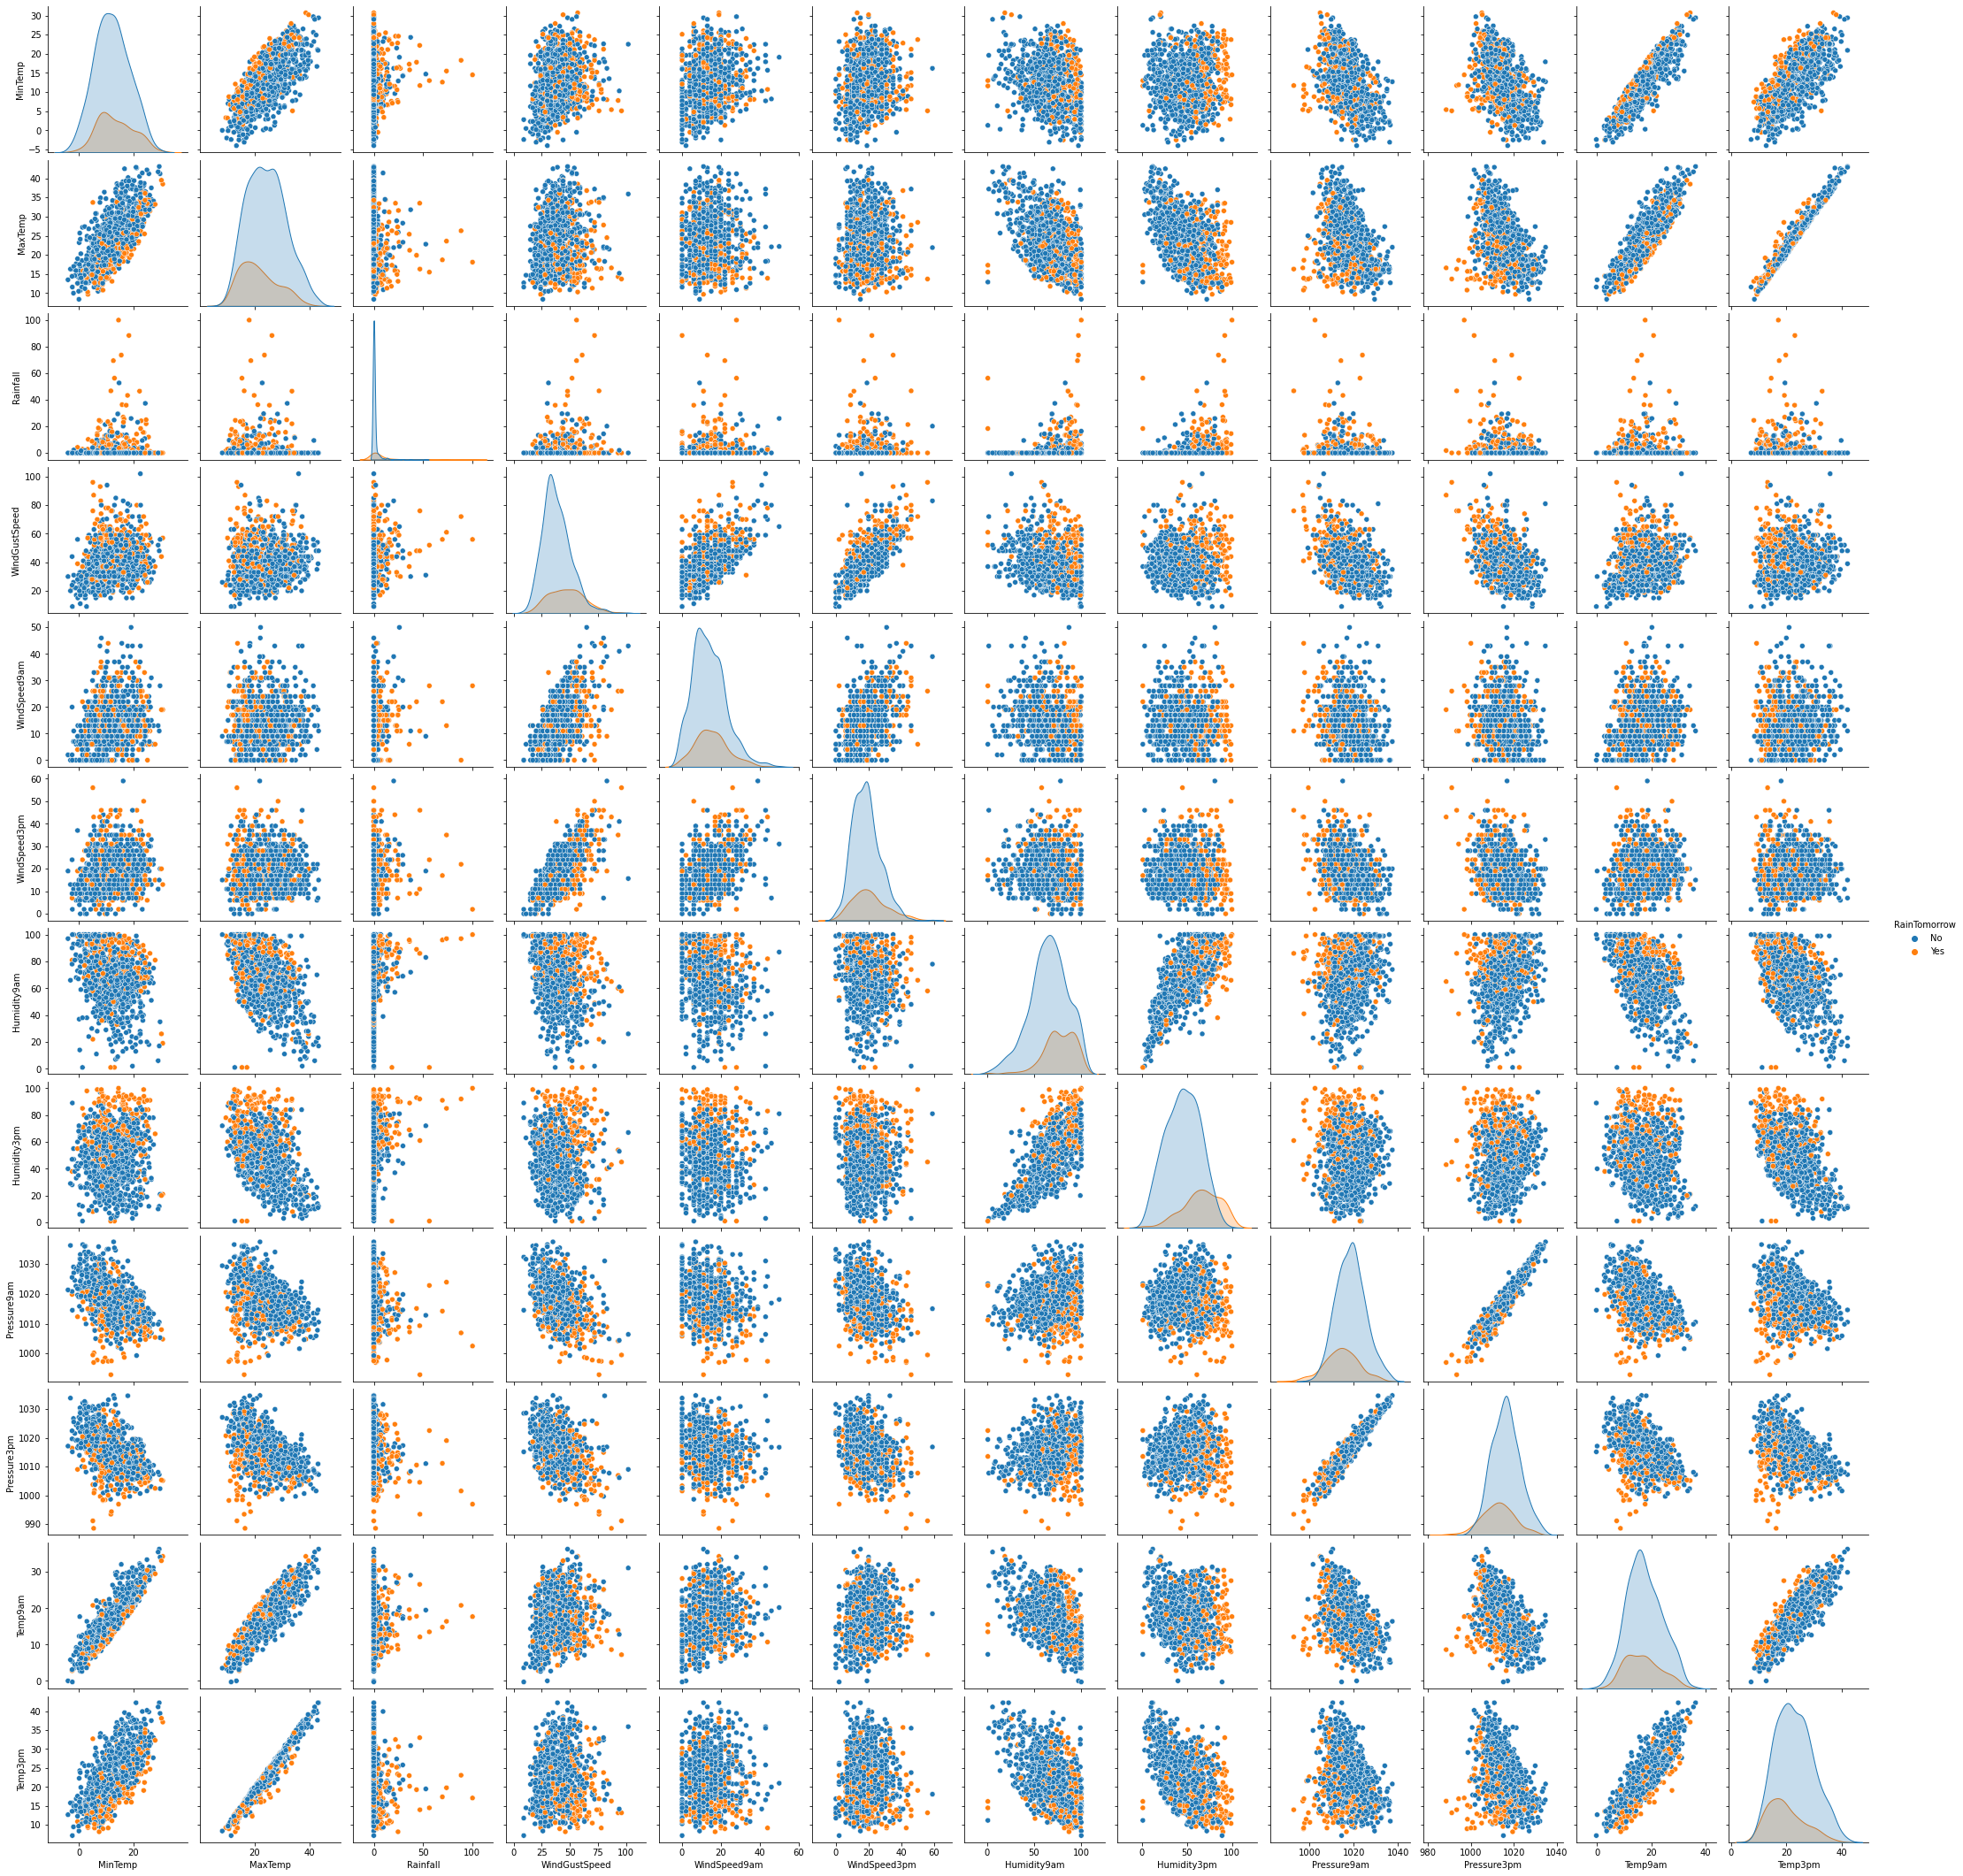

In [87]:
sns.pairplot(data=df.sample(1000)
             , diag_kind='kde'
             , hue='RainTomorrow'
            )

**Distribution plot of Humidity at 3PM split by value of target variable**\
Based on the below plot we can infer that the humidity in the evening is typically higher is it was going to rain on the next day 

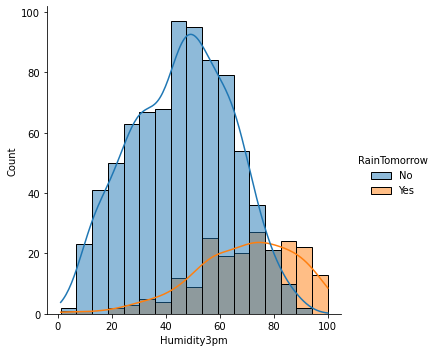

In [88]:
sns.displot(data=df.sample(1000)
           , x='Humidity3pm'
           , hue='RainTomorrow'
           , kde=True)

**Scatter plot between Temperature and rainfall**

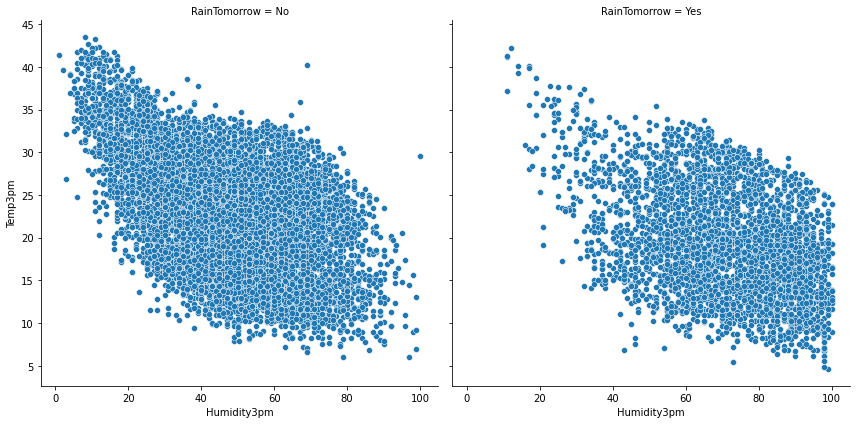

In [89]:
g = sns.relplot(data=df[df.Date.dt.year==2010]
            , y='Temp3pm', x='Humidity3pm'
            , col='RainTomorrow'#, hue='Location'
            , kind='scatter'
            , height=6, aspect=1
           )

**Timeseries plot of a few quantitative variables**

* Temperature vs Time (split by value of target variable)
* Humidity vs Time (split by value of target variable)
* Pressure vs Time (split by value of target variable)
* Temperature vs Time (split by value of target variable)


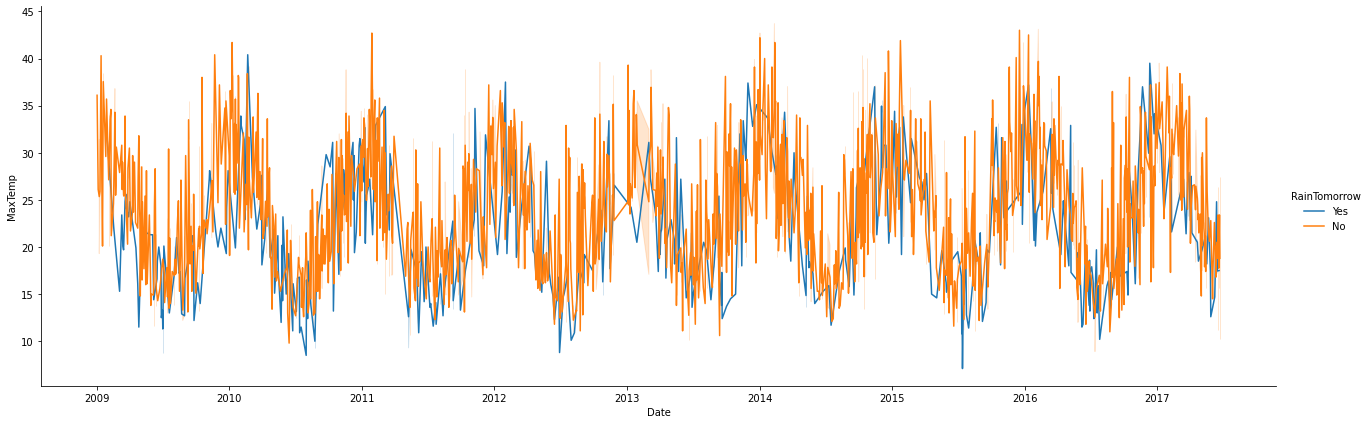

In [90]:
# Max Temperature vs Time (split by value of target variable)
sns.relplot(data=df.sample(2000)
           , x='Date', y='MaxTemp'
           , hue='RainTomorrow'
           , kind='line'
           , height=6, aspect=3
           )

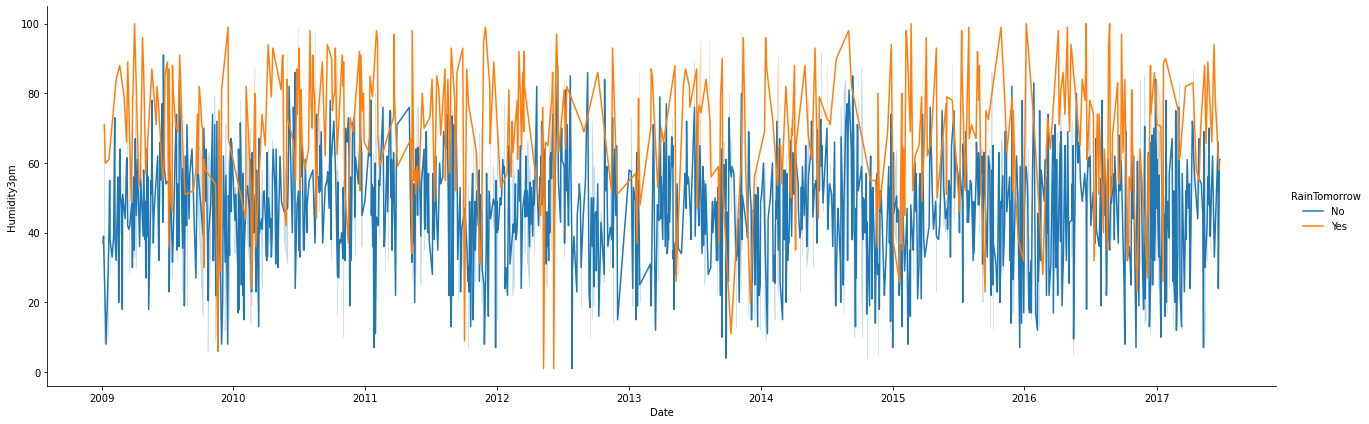

In [91]:
# Humidity vs Time (split by value of target variable)
sns.relplot(data=df.sample(2000)
           , x='Date', y='Humidity3pm'
           , hue='RainTomorrow'
           , kind='line'
           , height=6, aspect=3
           )

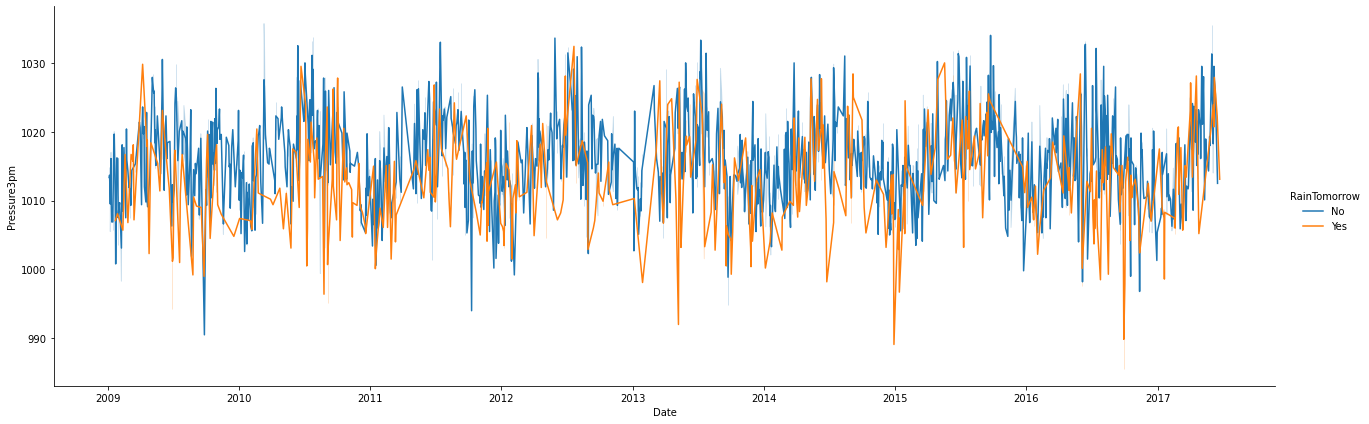

In [92]:
# Pressure vs Time (split by value of target variable)
sns.relplot(data=df.sample(2000)
           , x='Date', y='Pressure3pm'
           , hue='RainTomorrow'
           , kind='line'
           , height=6, aspect=3
           )

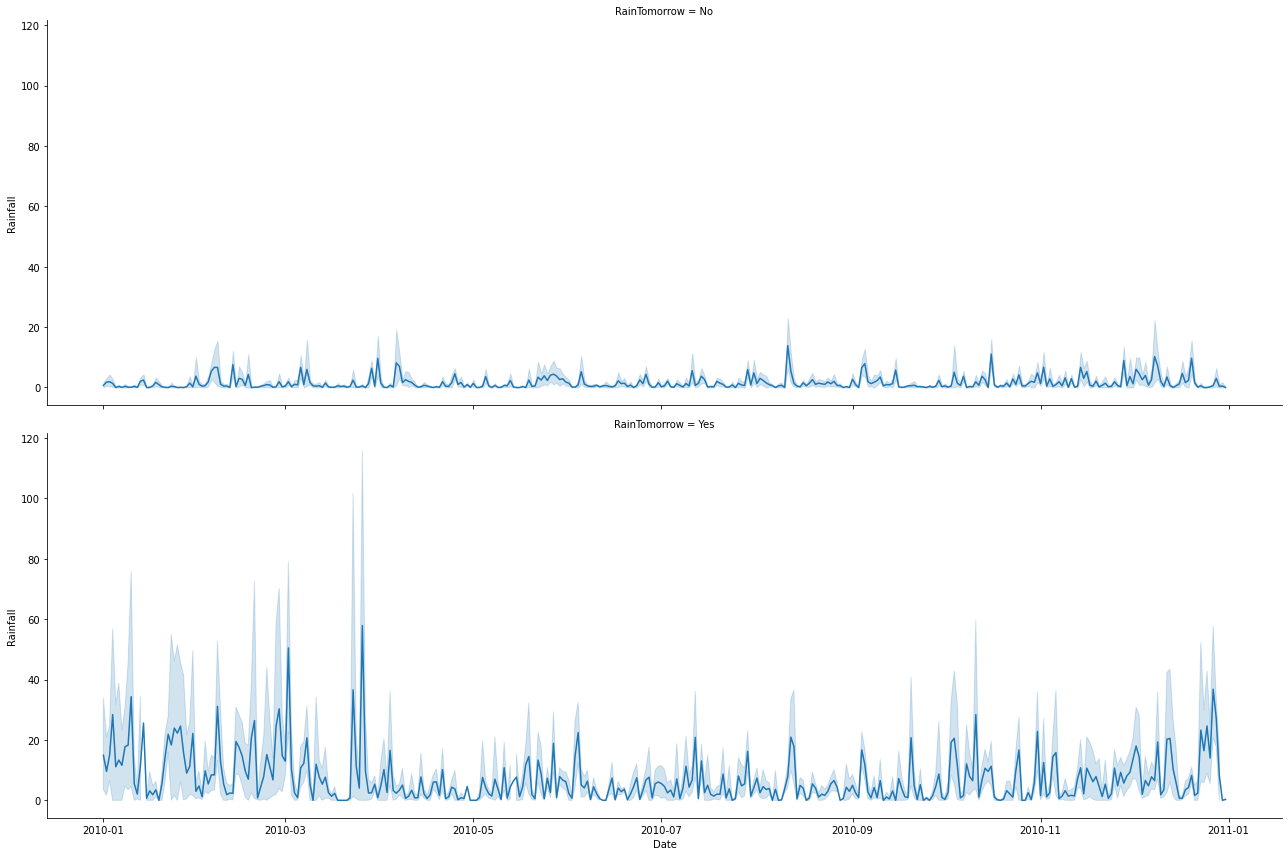

In [93]:
sns.relplot(data=df[df.Date.dt.year==2010]
            , x='Date', y='Rainfall'
            , row='RainTomorrow'#, hue='Location'
            , kind='line'
            , height=6, aspect=3
           )

**Adding derived variables**

In [94]:
# Adding additional columns to the dataset
df['temp_day_range'] = df['MaxTemp']-df['MinTemp']

In [95]:
df

Date  Location  MinTemp  MaxTemp  Rainfall WindGustDir  \
96504  2009-01-01  Adelaide     16.9     22.9       0.0          SW   
96505  2009-01-02  Adelaide     13.9     24.1       0.0          SE   
96506  2009-01-03  Adelaide     13.8     29.1       0.0          SW   
96507  2009-01-04  Adelaide     15.1     33.3       0.0           W   
96508  2009-01-05  Adelaide     14.6     30.5       0.0          SW   
...           ...       ...      ...      ...       ...         ...   
108565 2017-06-20   Woomera      5.6     19.7       0.0           N   
108566 2017-06-21   Woomera      5.8     19.9       0.0         ENE   
108567 2017-06-22   Woomera      7.8     19.0       0.0         NNE   
108568 2017-06-23   Woomera      8.0     22.5       0.0         NNW   
108569 2017-06-24   Woomera     11.5     20.9       0.0           W   

        WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  \
96504            50.0         SW         SW          17.0          20.0   
96505            37.0        SSE        ESE          17.0          13.0   
96506            30.0          E         SW           9.0          13.0   
96507            31.0        NNE         SW           2.0          13.0   
96508            26.0        WSW         SW           4.0          15.0   
...               ...        ...        ...           ...           ...   
108565           20.0          E        ESE           9.0           7.0   
108566           22.0        ESE        ESE          11.0           9.0   
108567           31.0        ENE        NNW          13.0          17.0   
108568           33.0          N         NW          13.0          15.0   
108569           33.0        WSW        WSW           9.0          20.0   

        Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  \
96504          58.0         40.0       1011.3       1012.4     18.1     22.5   
96505          39.0         25.0       1020.9       1018.5     16.1     22.7   
96506          26.0         15.0       1017.6       1014.7     21.9     28.2   
96507          25.0          7.0       1013.8       1012.2     24.2     32.2   
96508          28.0         22.0       1015.0       1013.2     22.3     29.2   
...             ...          ...          ...          ...      ...      ...   
108565         61.0         28.0       1028.1       1025.9     11.1     19.2   
108566         52.0         22.0       1027.9       1025.1     11.1     19.1   
108567         48.0         37.0       1025.8       1022.2     11.1     18.0   
108568         57.0         31.0       1021.0       1018.2     11.5     21.5   
108569         61.0         35.0       1019.5       1017.5     12.5     20.7   

       RainToday RainTomorrow  temp_day_range  
96504         No           No             6.0  
96505         No           No            10.2  
96506         No           No            15.3  
96507         No           No            18.2  
96508         No           No            15.9  
...          ...          ...             ...  
108565        No           No            14.1  
108566        No           No            14.1  
108567        No           No            11.2  
108568        No           No            14.5  
108569        No           No             9.4  

[124026 rows x 20 columns]

### Further Analysis

**Predictive Modeling**
1. Train test split: Given this is a timeserie data, we would split the data based on dates, with the most recent slice of data as test set.
    * If we did not treat this as a timeseries dataset, given the data is imbalanced interms (# days with no rain > # of days with rain) of the labels, we could do a startified sampling based on labels
2. Data Pre-processing: Transformations & Pipelines 
    * Explore Discretizatoin of quantitative variables
    * Try Scaling (Standardize/Normalize) the numerical variables
    * Try OrdinalEncoder/OneHotEncoder to pre-process categorical variables
3. This would be a Binary classificatio problem. train a few candidate models for classification
4. Use cross validation for model selection and hyper-parameter tuning (Grid/Randomized search CV)
5. Evaluate Generalization error of the chosen model


**Timeseries Analysis**
1. Test the data for auto-correlation using Durbin Watson test or Ljung-Box tests
2. ACF & PACF plot are also a visual way to check for Auto-correlation 
3. The Adj. Dickey-Fuller test (ADF) is used to check for stationarity in timeseries data